In [1]:
import numpy as np
import pandas as pd
#Encodeurs
from sklearn.preprocessing import OneHotEncoder, RobustScaler, StandardScaler, MinMaxScaler, PolynomialFeatures
#Preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
#Estimateurs
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.ensemble import GradientBoostingRegressor

import mlflow
from utils import mlflow_it

ModuleNotFoundError: No module named 'mlflow'

In [ ]:
data = pd.read_csv('data/bronze.csv')

In [ ]:
X = data.drop(['MEDV'], axis=1)
y = data.MEDV
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [ ]:
numerical_features = X.select_dtypes(include=['int','float']).columns

In [ ]:
categorical_features = X.select_dtypes(include=['bool']).columns

In [ ]:
std = StandardScaler()
minmax = MinMaxScaler()
rbst = RobustScaler()

scalers = [std, minmax, rbst]


In [ ]:
lnr = LinearRegression()
ridge = Ridge()
lasso = Lasso()
gbr = GradientBoostingRegressor()

In [ ]:
scaler = minmax

estimator = GradientBoostingRegressor(
    subsample = 0.8,
    n_estimators=500,
    min_samples_split=5,
    min_samples_leaf=2,
    max_depth=3,
    learning_rate=0.09000000000000001
    )

In [ ]:
preprocessor = make_column_transformer(
    (OneHotEncoder(sparse_output=True), categorical_features),
    (scaler, numerical_features),
    (PolynomialFeatures(degree=3, include_bias=False), numerical_features),
    remainder='passthrough'
)

In [ ]:
pipeline = make_pipeline(
    preprocessor,
    estimator
)

In [ ]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  Index(['CHAS'], dtype='object')),
                                                 ('robustscaler',
                                                  RobustScaler(),
                                                  Index(['CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT'],
      dtype='object')),
                                                 ('polynomialfeatures',
                                                  PolynomialFeatures(degree=3,
                                                                     include_bias=False),
                                                  Index(['CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT'],
      dtype='object'))])),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(learning_rate=0.09000000000000001,
                                           min_samples_leaf=2,
                                           min_samples_split=5,
                                           n_estimators=500, subsample=0.8))])

In [ ]:
score = pipeline.score(X_test, y_test)
score


0.9267766384378474

In [ ]:
mlflow_it(pipeline, X_train, y_train, X_test, y_test)

/home/apprenant/miniconda3/envs/pycaret/lib/python3.8/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2023/06/13 11:45:37 WARNING mlflow.pyfunc: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - mlflow (current: 2.4.1, required: mlflow==2.4)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
2023/06/13 11:45:38 INFO mlflow.models.evaluation.base: Evaluating the model with the default evaluator.
2023/06/13 11:45:38 WARNING mlflow.models.evaluation.default_evaluator: Skip logging model explainability insights because the shap explainer None requires all feature values to be numeric, and each feature column must only contain scalar values.


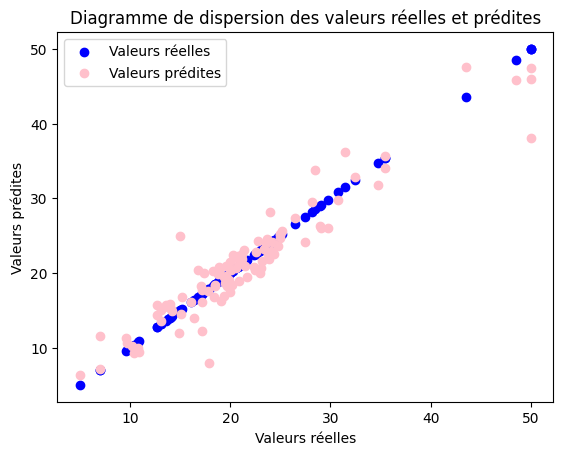

In [ ]:
import matplotlib.pyplot as plt

# Calcul des valeurs prédites
y_pred = pipeline.predict(X_test)

# Diagramme de dispersion avec valeurs réelles en bleu
plt.scatter(y_test, y_test, c='b', label='Valeurs réelles')

# Diagramme de dispersion avec valeurs prédites en rose
plt.scatter(y_test, y_pred, c='pink', label='Valeurs prédites')

plt.xlabel('Valeurs réelles')
plt.ylabel('Valeurs prédites')
plt.title('Diagramme de dispersion des valeurs réelles et prédites')
plt.legend()
plt.show()


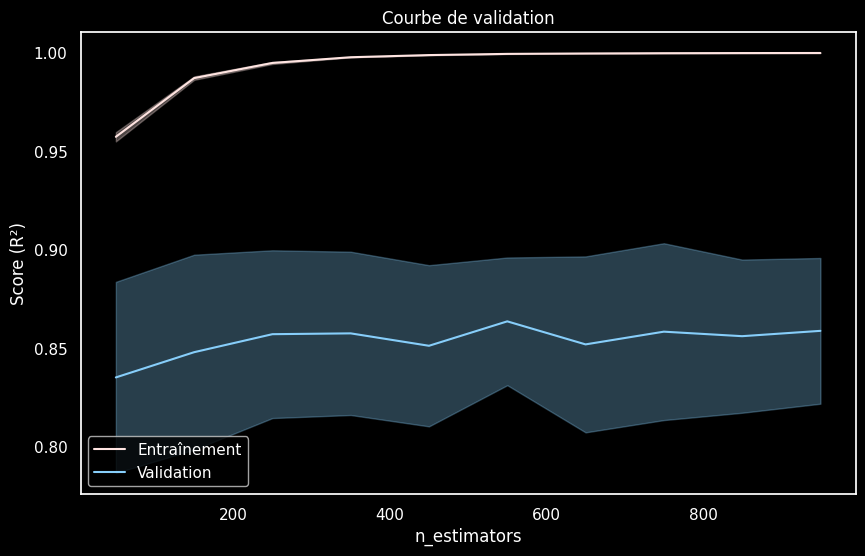

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import validation_curve

# Définir les hyperparamètres à évaluer
param_name = "n_estimators"
param_range = np.arange(50, 1000, 100)

# Calculer les scores de validation croisée pour différentes valeurs de l'hyperparamètre
train_scores, valid_scores = validation_curve(estimator, X_train, y_train, param_name=param_name, param_range=param_range, cv=5, scoring="r2")

# Calculer les moyennes et les écarts-types des scores de validation
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
valid_mean = np.mean(valid_scores, axis=1)
valid_std = np.std(valid_scores, axis=1)

sns.set_theme(style='darkgrid')

# Tracer la courbe de validation
plt.style.use("dark_background")
plt.figure(figsize=(10, 6))
plt.plot(param_range, train_mean, label="Entraînement", color="mistyrose")
plt.plot(param_range, valid_mean, label="Validation", color="lightskyblue")
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.3, color="mistyrose")
plt.fill_between(param_range, valid_mean - valid_std, valid_mean + valid_std, alpha=0.3, color="lightskyblue")
plt.title("Courbe de validation")
plt.xlabel(param_name)
plt.ylabel("Score (R²)")
plt.legend()
plt.grid(False)
plt.gca().set_facecolor('black')
plt.show()


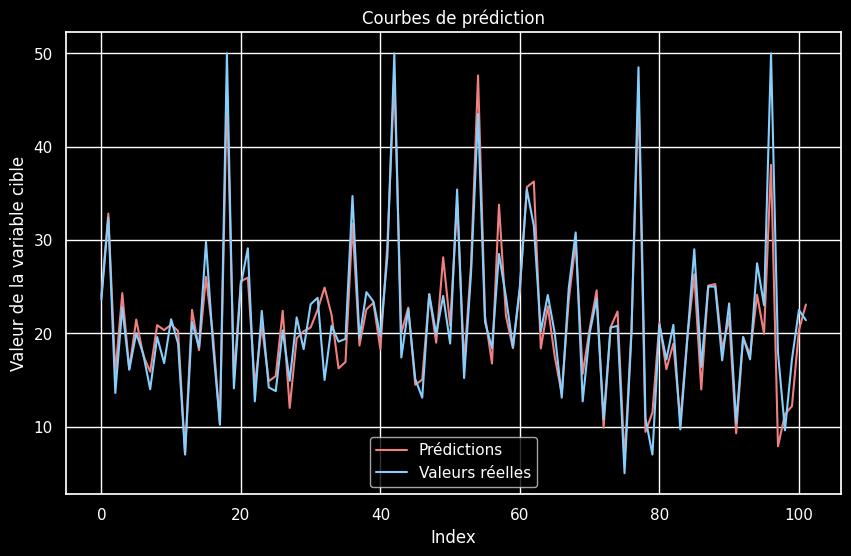

In [ ]:
import matplotlib.pyplot as plt

# Prédire les valeurs sur les données de test
y_pred = pipeline.predict(X_test)

# Tracer les courbes de prédiction
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_pred)), y_pred, label="Prédictions", color="lightcoral")
plt.plot(range(len(y_test)), y_test, label="Valeurs réelles", color="lightskyblue")

plt.title("Courbes de prédiction")
plt.xlabel("Index")
plt.ylabel("Valeur de la variable cible")
plt.legend()
plt.show()




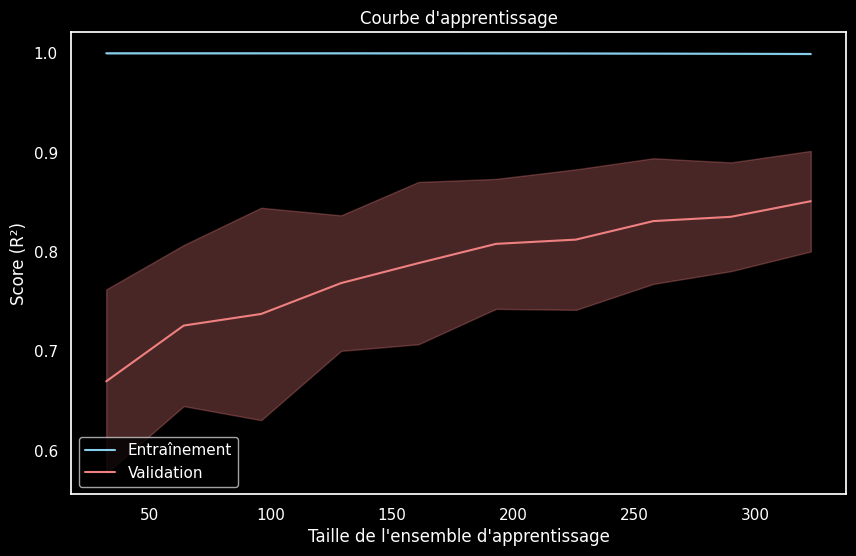

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# Définir les tailles des ensembles d'apprentissage
train_sizes, train_scores, valid_scores = learning_curve(estimator, X_train, y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=5, scoring="r2")

# Calculer les moyennes et les écarts-types des scores d'apprentissage et de validation
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
valid_mean = np.mean(valid_scores, axis=1)
valid_std = np.std(valid_scores, axis=1)

# Tracer la courbe d'apprentissage
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label="Entraînement", color="skyblue")
plt.plot(train_sizes, valid_mean, label="Validation", color="lightcoral")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.3, color="skyblue")
plt.fill_between(train_sizes, valid_mean - valid_std, valid_mean + valid_std, alpha=0.3, color="lightcoral")
plt.title("Courbe d'apprentissage")
plt.xlabel("Taille de l'ensemble d'apprentissage")
plt.ylabel("Score (R²)")
plt.legend()
plt.grid(False)
plt.show()


/tmp/ipykernel_378201/2649124215.py:18: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-pastel")


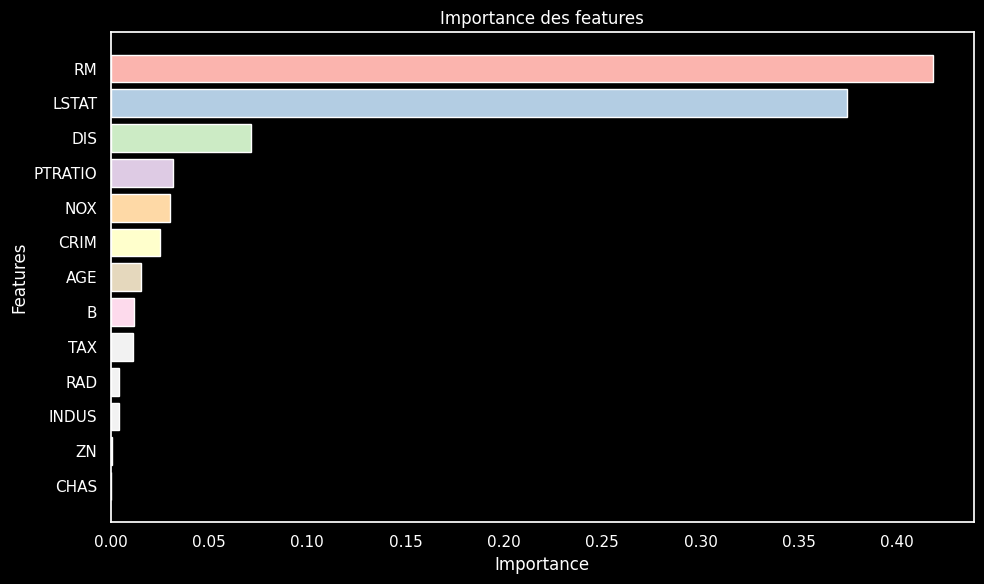

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor

# Création du modèle
model = GradientBoostingRegressor()
model.fit(X_train, y_train)

# Obtention des importances de features
importances = model.feature_importances_
feature_names = X.columns

# Trier les importances par ordre croissant
indices = np.argsort(importances)

# Tracer la visualisation des feature importances avec couleurs inversées
plt.style.use("seaborn-pastel")
cmap = plt.get_cmap("Pastel1")
cmap_colors = list(reversed(cmap(range(len(importances)))))

plt.figure(figsize=(10, 6))
plt.barh(range(len(importances)), importances[indices], color=cmap_colors)
plt.yticks(range(len(importances)), feature_names[indices])
plt.title("Importance des features")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.grid(False)
plt.tight_layout()
plt.show()


In [ ]:
import shap

# Extraction du modèle final du pipeline
model = pipeline.named_steps['gradientboostingregressor']

# Calcul des valeurs SHAP
explainer = shap.Explainer(model, feature_perturbation='interventional')
shap_values = explainer.shap_values(X_test)

# Tracé de la visualisation SHAP
shap.summary_plot(shap_values, X_test, plot_type="bar", color='pastel1', show=False)
plt.title("Feature Importance (SHAP)")
plt.xlabel("SHAP Value")
plt.ylabel("Features")
plt.xticks(rotation=45)
plt.show()


: 

: 